In [23]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import StringType,BooleanType,DateType, IntegerType
from pyspark.sql.functions import to_timestamp, upper, col
from pyspark.sql.functions import rank
from pyspark.sql.window import Window
from pyspark.sql.functions import *
from pyspark.ml.feature import StringIndexer, OneHotEncoder, Tokenizer, StopWordsRemover, Word2Vec, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.types import StringType, DoubleType 
from pyspark.ml.linalg import Vectors

from pyspark.ml.evaluation import RegressionEvaluator, BinaryClassificationEvaluator

from pyspark.ml.clustering import KMeans

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
spark = SparkSession.builder.appName('BigDataProject').getOrCreate()

#change configuration settings on Spark 
conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '4g'), ('spark.app.name', 'Spark Updated Conf'), ('spark.executor.cores', '4'), ('spark.cores.max', '4'), ('spark.driver.memory','4g')])
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)

In [5]:
raw_df = spark.read.csv("/user/abhiniti/project/mod_df_3.9.csv", inferSchema=True, header=True)

In [6]:
df = raw_df

In [7]:
# Convert city, state and zip to numeric categorical
for y in ['city', 'state', 'zip5']:
    print(y)
    indexer = StringIndexer(inputCol=str(y), outputCol=str(y)+"Index")
    ohe = OneHotEncoder(inputCol = str(y)+"Index", outputCol = str(y)+"Vector")
    df = indexer.fit(df).transform(df)
    df = ohe.transform(df)

city
state
zip5


In [47]:
df.printSchema()

root
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- physical_address: string (nullable = true)
 |-- zip5: integer (nullable = true)
 |-- property_type: string (nullable = true)
 |-- rank: integer (nullable = true)
 |-- sale_date: timestamp (nullable = true)
 |-- sale_price: double (nullable = true)
 |-- num_units: integer (nullable = true)
 |-- year_built: integer (nullable = true)
 |-- num_sales: integer (nullable = true)
 |-- zip_num_schools: integer (nullable = true)
 |-- city_num_schools: integer (nullable = true)
 |-- zip_st_ratio: double (nullable = true)
 |-- city_st_ratio: double (nullable = true)
 |-- CPIHOSNS: double (nullable = true)
 |-- ZVHI: double (nullable = true)
 |-- Median_Income: double (nullable = true)
 |-- sum(count): integer (nullable = true)
 |-- avg(Hospital overall rating): double (nullable = true)
 |-- CHILDREN_CNT: integer (nullable = true)
 |-- CHILDREN_RATE: double (nullable = true)
 |-- CHRONIC DISEASE_CNT: integer (nullabl

### Modeling

In [13]:
## create flag var
df = df.withColumn(
    'price_flag',
    F.when(F.col("sale_price") > F.col("prev_sale_price"), 1)\
    .otherwise(0)
)

In [8]:
from pyspark.ml.feature import VectorAssembler

In [15]:
lin_reg_df = df.filter(df['prev_sale_price'] > 0).na.fill(0)
lin_reg_df = lin_reg_df.withColumn('last_sale_days', datediff('sale_date',col("prev_sale_date")))
lin_reg_df = lin_reg_df.withColumn('last_sale_days', datediff('sale_date',col("prev_sale_date")))
lin_reg_df = lin_reg_df.withColumn('year_built', F.regexp_replace('year_built', ',', '').cast('decimal(12,2)'))
lin_reg_df = lin_reg_df.withColumn('sale_price', F.regexp_replace('sale_price', ',', '').cast('decimal(12,2)')).na.fill(0)
lin_reg_df = lin_reg_df.filter(col('sale_price') <= 1000000).filter(col('sale_price') >= 100000)

In [53]:
lin_reg_df.printSchema()

root
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- physical_address: string (nullable = true)
 |-- zip5: integer (nullable = true)
 |-- property_type: string (nullable = true)
 |-- rank: integer (nullable = true)
 |-- sale_date: timestamp (nullable = true)
 |-- sale_price: decimal(12,2) (nullable = true)
 |-- num_units: integer (nullable = true)
 |-- year_built: decimal(12,2) (nullable = true)
 |-- num_sales: integer (nullable = true)
 |-- zip_num_schools: integer (nullable = true)
 |-- city_num_schools: integer (nullable = true)
 |-- zip_st_ratio: double (nullable = false)
 |-- city_st_ratio: double (nullable = false)
 |-- CPIHOSNS: double (nullable = false)
 |-- ZVHI: double (nullable = false)
 |-- Median_Income: double (nullable = false)
 |-- sum(count): integer (nullable = true)
 |-- avg(Hospital overall rating): double (nullable = false)
 |-- CHILDREN_CNT: integer (nullable = true)
 |-- CHILDREN_RATE: double (nullable = false)
 |-- CHRONIC DISEASE_C

In [10]:
predictors = ['year_built', 'prev_sale_price', 'last_sale_days', 'CPIHOSNS', 'cityVector', 'stateVector', 'zip5Vector']
# lin_reg_df = lin_reg_df.select(predictors).printSchema()
# lin_reg_df.select(predictors).show(1,vertical=True)

In [54]:
# price_flag, sale_price
y_var = 'sale_price'
# predictors = ['year_built', 'prev_sale_price', 'last_sale_days', 'CPIHOSNS']
vectorAssembler = VectorAssembler(inputCols = predictors, outputCol = 'features')
vinput_data = vectorAssembler.transform(lin_reg_df)
vinput_data = vinput_data.select(['features', y_var])
vinput_data.show(1)

+--------------------+----------+
|            features|sale_price|
+--------------------+----------+
|(1530,[0,1,2,3,11...| 358000.00|
+--------------------+----------+
only showing top 1 row



In [55]:
# Train/Test Split
train_df, test_df = vinput_data.randomSplit([.7,.3],seed=1234)

### Gradient Boost Regressor

In [56]:
from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(featuresCol = 'features', labelCol = 'sale_price', maxIter=5)
gbt_model = gbt.fit(train_df)

In [57]:
gbt_predictions_train = gbt_model.transform(train_df)
gbt_predictions_test = gbt_model.transform(test_df)

In [59]:
## Train data
gbt_evaluator = RegressionEvaluator(
    labelCol="sale_price", predictionCol="prediction", metricName="rmse")
rmse = gbt_evaluator.evaluate(gbt_predictions_train)
print("Root Mean Squared Error (RMSE) on train data = %g" % rmse)

gbt_evaluator = RegressionEvaluator(
    labelCol="sale_price", predictionCol="prediction", metricName="r2")
rmse = gbt_evaluator.evaluate(gbt_predictions_train)
print("R Squared (R2) on train data = %g" % rmse)

Root Mean Squared Error (RMSE) on train data = 130769
R Squared (R2) on train data = 0.577343


In [91]:
## Train data
gbt_evaluator = RegressionEvaluator(
    labelCol="sale_price", predictionCol="prediction", metricName="mae")
rmse = gbt_evaluator.evaluate(gbt_predictions_train)
print("Mean Absolute Error (MAE) on train data = %g" % rmse)

gbt_evaluator = RegressionEvaluator(
    labelCol="sale_price", predictionCol="prediction", metricName="mse")
rmse = gbt_evaluator.evaluate(gbt_predictions_train)
print("Mean Squared Error (MSE) on train data = %g" % rmse)

Mean Absolute Error (MAE) on train data = 92808.5
Mean Squared Error (MSE) on train data = 1.71214e+10


In [58]:
## Test data
gbt_evaluator = RegressionEvaluator(
    labelCol="sale_price", predictionCol="prediction", metricName="rmse")
rmse = gbt_evaluator.evaluate(gbt_predictions_test)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

gbt_evaluator = RegressionEvaluator(
    labelCol="sale_price", predictionCol="prediction", metricName="r2")
rmse = gbt_evaluator.evaluate(gbt_predictions_test)
print("R Squared (R2) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 132454
R Squared (R2) on test data = 0.566935


In [59]:
## test data
gbt_evaluator = RegressionEvaluator(
    labelCol="sale_price", predictionCol="prediction", metricName="mae")
rmse = gbt_evaluator.evaluate(gbt_predictions_test)
print("Mean Absolute Error (MAE) on test data = %g" % rmse)

gbt_evaluator = RegressionEvaluator(
    labelCol="sale_price", predictionCol="prediction", metricName="mse")
rmse = gbt_evaluator.evaluate(gbt_predictions_test)
print("Mean Squared Error (MSE) on test data = %g" % rmse)

Mean Absolute Error (MAE) on test data = 94337.3
Mean Squared Error (MSE) on test data = 1.75441e+10


In [61]:
dir(gbt_model)

['__class__',
 '__del__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__metaclass__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_call_java',
 '_clear',
 '_copyValues',
 '_copy_params',
 '_create_from_java_class',
 '_create_params_from_java',
 '_defaultParamMap',
 '_dummy',
 '_empty_java_param_map',
 '_from_java',
 '_java_obj',
 '_make_java_param_pair',
 '_new_java_array',
 '_new_java_obj',
 '_paramMap',
 '_params',
 '_randomUID',
 '_resetUid',
 '_resolveParam',
 '_set',
 '_setDefault',
 '_shouldOwn',
 '_to_java',
 '_transfer_param_map_from_java',
 '_transfer_param_map_to_java',
 '_transfer_params_from_java',
 '_transfer_params_to_java',
 '_transform',
 'cacheNodeIds',
 'checkpointInterval',
 'copy',
 'evaluateEachIte

In [62]:
# gbt_model.featureImportances
# gbt_model.stages[-1].featureImportances

In [60]:
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))


In [62]:
feature_imp = ExtractFeatureImp(gbt_model.featureImportances, train_df, "features")

Text(0,0.5,'Feature Importance')

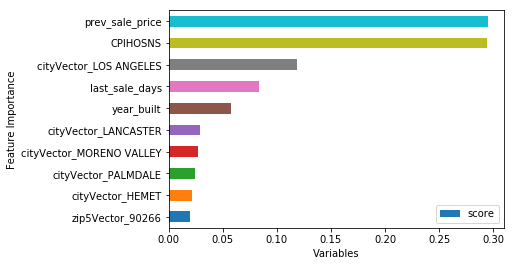

In [63]:
ax = feature_imp.sort_values(by='score', ascending=True).tail(10).plot(kind='barh', x = 'name', y = 'score')\

ax.set_xlabel("Variables")
ax.set_ylabel("Feature Importance")

### Linear Regression

In [82]:
train_df_lin = train_df.withColumnRenamed('sale_price', 'label')

In [83]:
from pyspark.ml.regression import GeneralizedLinearRegression
glr = GeneralizedLinearRegression(family="gaussian", link="identity", maxIter=10, 
regParam=0.0)
model = glr.fit(train_df_lin)

In [84]:
# summary = model.summary
# print("Coefficients: " + str(model.coefficients))
# print("P Values: " + str(summary.pValues))
# dir(model.summary)

In [85]:
model.summary.pValues

[2.903939311238446e-10, 0.0, 0.0, 0.0, 2.234500584563648e-08]

In [87]:
linreg_predictions_train = model.transform(train_df)
linreg_predictions_test = model.transform(test_df)

In [ ]:
## with city, state, zip

In [74]:
## Train data
linreg_evaluator = RegressionEvaluator(
    labelCol="sale_price", predictionCol="prediction", metricName="rmse")
rmse = linreg_evaluator.evaluate(linreg_predictions_train)
print("Root Mean Squared Error (RMSE) on train data = %g" % rmse)

linreg_evaluator = RegressionEvaluator(
    labelCol="sale_price", predictionCol="prediction", metricName="r2")
rmse = linreg_evaluator.evaluate(linreg_predictions_train)
print("R Squared (R2) on train data = %g" % rmse)

Root Mean Squared Error (RMSE) on train data = 140034
R Squared (R2) on train data = 0.515326


In [75]:
## Test data
linreg_evaluator = RegressionEvaluator(
    labelCol="sale_price", predictionCol="prediction", metricName="rmse")
rmse = linreg_evaluator.evaluate(linreg_predictions_test)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

linreg_evaluator = RegressionEvaluator(
    labelCol="sale_price", predictionCol="prediction", metricName="r2")
rmse = linreg_evaluator.evaluate(linreg_predictions_test)
print("R Squared (R2) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 140339
R Squared (R2) on test data = 0.51542


In [86]:
### without city, state, zip

In [88]:
## Train data
linreg_evaluator = RegressionEvaluator(
    labelCol="sale_price", predictionCol="prediction", metricName="rmse")
rmse = linreg_evaluator.evaluate(linreg_predictions_train)
print("Root Mean Squared Error (RMSE) on train data = %g" % rmse)

linreg_evaluator = RegressionEvaluator(
    labelCol="sale_price", predictionCol="prediction", metricName="r2")
rmse = linreg_evaluator.evaluate(linreg_predictions_train)
print("R Squared (R2) on train data = %g" % rmse)

Root Mean Squared Error (RMSE) on train data = 187996
R Squared (R2) on train data = 0.127233


In [89]:
## Test data
linreg_evaluator = RegressionEvaluator(
    labelCol="sale_price", predictionCol="prediction", metricName="rmse")
rmse = linreg_evaluator.evaluate(linreg_predictions_test)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

linreg_evaluator = RegressionEvaluator(
    labelCol="sale_price", predictionCol="prediction", metricName="r2")
rmse = linreg_evaluator.evaluate(linreg_predictions_test)
print("R Squared (R2) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 187625
R Squared (R2) on test data = 0.128691


### Gradient Boost Classifier

In [21]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(labelCol=y_var, featuresCol="features", maxIter=5)
gbt_model = gbt.fit(train_df)

In [27]:
gbt_predictions_train = gbt_model.transform(train_df)
gbt_predictions_test = gbt_model.transform(test_df)

In [28]:
gbt_predictions_train.columns

['features', 'price_flag', 'rawPrediction', 'probability', 'prediction']

In [25]:
dir(BinaryClassificationEvaluator)

['__class__',
 '__del__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__metaclass__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_call_java',
 '_clear',
 '_copyValues',
 '_copy_params',
 '_create_from_java_class',
 '_create_params_from_java',
 '_dummy',
 '_empty_java_param_map',
 '_evaluate',
 '_from_java',
 '_make_java_param_pair',
 '_new_java_array',
 '_new_java_obj',
 '_randomUID',
 '_resetUid',
 '_resolveParam',
 '_set',
 '_setDefault',
 '_shouldOwn',
 '_to_java',
 '_transfer_param_map_from_java',
 '_transfer_param_map_to_java',
 '_transfer_params_from_java',
 '_transfer_params_to_java',
 'copy',
 'evaluate',
 'explainParam',
 'explainParams',
 'extractParamMap',
 'getLabelCol',
 'getMetricName',
 'getOrDefault',


In [32]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Create both evaluators
evaluatorMulti = MulticlassClassificationEvaluator(labelCol="price_flag", predictionCol="prediction")
evaluator = BinaryClassificationEvaluator(labelCol="price_flag", rawPredictionCol="prediction", metricName='areaUnderROC')

# Make predicitons
predictionAndprice_flag = gbt_predictions_train.select("price_flag", "prediction")

# Get metrics
acc = evaluatorMulti.evaluate(predictionAndprice_flag, {evaluatorMulti.metricName: "accuracy"})
f1 = evaluatorMulti.evaluate(predictionAndprice_flag, {evaluatorMulti.metricName: "f1"})
weightedPrecision = evaluatorMulti.evaluate(predictionAndprice_flag, {evaluatorMulti.metricName: "weightedPrecision"})
weightedRecall = evaluatorMulti.evaluate(predictionAndprice_flag, {evaluatorMulti.metricName: "weightedRecall"})
auc = evaluator.evaluate(predictionAndprice_flag)

In [33]:
acc

0.8751843355161602

In [34]:
f1

0.874785206860271

In [35]:
weightedPrecision

0.8739182538205961

In [36]:
weightedRecall

0.875607689558434

In [37]:
auc

0.8325805314422338

In [38]:
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))


In [41]:
feature_imp = ExtractFeatureImp(gbt_model.featureImportances, train_df, "features")
feature_imp

,idx,name,score
1,1,prev_sale_price,0.367510
3,3,CPIHOSNS,0.310575
2,2,last_sale_days,0.203691
0,0,year_built,0.082440
579,579,stateVector_CA,0.014693
9,9,cityVector_PALMDALE,0.006403
580,580,stateVector_FL,0.004769
4,4,cityVector_LOS ANGELES,0.003767
17,17,cityVector_HEMET,0.003042
683,683,zip5Vector_90266,0.002907


Text(0,0.5,'Feature Importance')

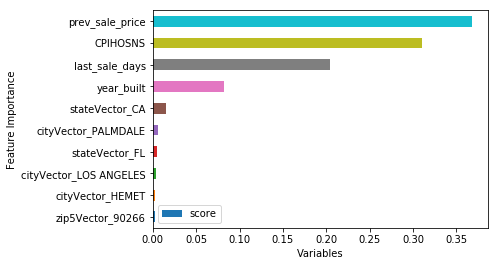

In [51]:
ax = feature_imp.sort_values(by='score', ascending=True).tail(10).plot(kind='barh', x = 'name', y = 'score')\

ax.set_xlabel("Variables")
ax.set_ylabel("Feature Importance")

In [52]:
## test results
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Create both evaluators
evaluatorMulti = MulticlassClassificationEvaluator(labelCol="price_flag", predictionCol="prediction")
evaluator = BinaryClassificationEvaluator(labelCol="price_flag", rawPredictionCol="prediction", metricName='areaUnderROC')

# Make predicitons
predictionAndprice_flag = gbt_predictions_test.select("price_flag", "prediction")

# Get metrics
acc = evaluatorMulti.evaluate(predictionAndprice_flag, {evaluatorMulti.metricName: "accuracy"})
f1 = evaluatorMulti.evaluate(predictionAndprice_flag, {evaluatorMulti.metricName: "f1"})
weightedPrecision = evaluatorMulti.evaluate(predictionAndprice_flag, {evaluatorMulti.metricName: "weightedPrecision"})
weightedRecall = evaluatorMulti.evaluate(predictionAndprice_flag, {evaluatorMulti.metricName: "weightedRecall"})
auc = evaluator.evaluate(predictionAndprice_flag)

In [53]:
print(acc)
print(f1)
print(weightedPrecision)
print(weightedRecall)

0.8758724641049104
0.8734326934843245
0.8732670721252781
0.8748824810961873
